In [1]:
%load_ext autoreload

# General case

$d(s) = e^{G_d s}$ with $0 \prec G_d$

$||x|| = \sqrt{x^T P x}$ with $0 \prec P$


**Corollary 1:** A linear continuous dilation in $\mathbb{R}^n$ is strictly monotone with respect to the weighted Euclidean norm

$$
\|x\| = \sqrt{x^T P x} \quad \text{with } 0 \prec P \in \mathbb{R}^{n \times n}
$$

if and only if 

$$
P G_d + G_d^T P \succ 0, \quad P \succ 0.
$$

## Finding $s_x \in \mathbb{R}$ such that $||d(-s_x)x|| = 1$

We have $s_x = ln(||x||_d)$

**Lemma 1:** If a linear continuous dilation $\mathbf{d}$ in $\mathbb{R}^n$ is monotone with respect to a norm $\|\cdot\|$, then 1) the function $\|\cdot\|_{\mathbf{d}} : \mathbb{R}^n \to [0,+\infty)$ implicitly defined by (5) is single-valued and continuous on $\mathbb{R}^n$; 2) there exist $\sigma_1, \sigma_2 \in \mathcal{K}_\infty$ such that:

$$
\sigma_1(\|x\|_{\mathbf{d}}) \leq \|x\| \leq \sigma_2(\|x\|_{\mathbf{d}}), \quad \forall x \in \mathbb{R}^n;
$$
$$
\sigma_1(\rho) =
\begin{cases}
    \rho^\alpha, & \text{if } \rho \leq 1, \\
    \rho^\beta, & \text{if } \rho > 1,
\end{cases}
\quad
\sigma_2(\rho) =
\begin{cases}
    \rho^\beta, & \text{if } \rho \leq 1, \\
    \rho^\alpha, & \text{if } \rho > 1.
\end{cases}
$$

$$
\alpha = \frac{\lambda_{\max} \left( P^{\frac{1}{2}} G_d P^{-\frac{1}{2}} + P^{-\frac{1}{2}} G_d^T P^{\frac{1}{2}} \right)}{2}
\geq \beta = \frac{\lambda_{\min} \left( P^{\frac{1}{2}} G_d P^{-\frac{1}{2}} + P^{-\frac{1}{2}} G_d^T P^{\frac{1}{2}} \right)}{2} > 0.
$$

So we have $$min(||x||^{1/\alpha},||x||^{1/\beta}) \leq ||x||_d \leq max(||x||^{1/\alpha},||x||^{1/\beta})$$

$$\implies ln(min(||x||^{1/\alpha},||x||^{1/\beta})) \leq s_x \leq ln(max(||x||^{1/\alpha},||x||^{1/\beta}))$$


# Anisotropic simple exemple 

A function $ f: \mathbb{R}^n \to \mathbb{R} $ is said to be $\textbf{homogeneous of degree} \; \nu $ with respect to an anisotropic dilation if it satisfies the scaling relation:

$
f(d(s) x) = e^{\nu s} f(x), \quad \forall x \in \mathbb{R}^n, \forall s \in  \mathbb{R}^n ,
$

where $ d(s) $ is the anisotropic dilation given by:

$
d(s) x = \begin{bmatrix}
e^{r_1 s} & 0 & \cdots & 0 \\
0 & e^{r_2 s} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & e^{r_d s}
\end{bmatrix} x.
$

ie $
G_d = \begin{bmatrix}
r_1 & 0 & \cdots & 0 \\
0 & r_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & r_n
\end{bmatrix}
$


**Target Function: Sum of Homogeneous Monomials**
We define the function:

$$
f(x_1, x_2) = c_1 |x_1|^{\alpha_{1,1}} |x_2|^{\alpha_{2,1}} + c_2 |x_1|^{\alpha_{1,2}} |x_2|^{\alpha_{2,2}}
$$

where the exponents satisfy the homogeneity condition:

$$
\alpha_{1,k} r_1 + \alpha_{2,k} r_2 = \nu.
$$

For our example:
- $ r_1 = 1, r_2 = 2 $,
- $ \nu = 3 $,

Thus, the function is:

$$
f(x_1, x_2) = 2 |x_1|^2 |x_2|^{0.5} - |x_1|^{0.5} |x_2|^{1.25}.
$$


In [4]:
import torch

# Set seed for reproducibility
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# --- Define anisotropic homogeneous function ---
r1, r2 = 1.0, 2.0
nu = 3.0
Gd = torch.diag(torch.tensor([r1, r2], device=device))
P  = torch.eye(2, device=device)

alpha_1 = torch.tensor([2.0, 0.5], device=device)
alpha_2 = torch.tensor([0.5, 1.25], device=device)
coeffs  = torch.tensor([2.0, -1.0], device=device)
assert torch.all(alpha_1 * r1 + alpha_2 * r2 == nu), "Function is not homogeneous"

def f_anisotropic(x):
    """
    Computes the anisotropic homogeneous function f(x).
    """
    terms = torch.stack([
        coeffs[k] * torch.abs(x[:, 0])**alpha_1[k] * torch.abs(x[:, 1])**alpha_2[k]
        for k in range(len(coeffs))
    ], dim=0)
    return terms.sum(dim=0)

cuda


In [2]:
# --- Generate dataset and split into train/test ---

from torch.utils.data import TensorDataset, DataLoader, random_split

N = 1000
batch_size = 100
X = torch.randn(N, 2, device=device)
y = f_anisotropic(X).unsqueeze(-1)
full_dataset = TensorDataset(X, y)

train_size = int(0.5 * N)
test_size  = N - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# HNN vs MLP

In [6]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn

# --- Define models ---
hidden_dim = 128
output_dim = 1

# 1) HomogeneousNN (your custom model)
model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

# 2) Standard MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.name = 'MLP'
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=2, hidden_dim=2*hidden_dim, output_dim=output_dim).to(device)

model_hnn.apply(initialize_weights)
model_mlp.apply(initialize_weights)


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

Epoch 100 | HNN Train: 1.4411 | Test: 1.3520 || MLP Train: 3.7319 | Test: 4.1897
Epoch 200 | HNN Train: 1.3938 | Test: 1.2510 || MLP Train: 3.7189 | Test: 4.1706
Epoch 300 | HNN Train: 1.3940 | Test: 1.2510 || MLP Train: 3.7156 | Test: 4.1682
Epoch 400 | HNN Train: 1.3939 | Test: 1.2531 || MLP Train: 3.7116 | Test: 4.1656
Epoch 500 | HNN Train: 1.3934 | Test: 1.2469 || MLP Train: 3.7082 | Test: 4.1622
Epoch 600 | HNN Train: 1.3938 | Test: 1.2471 || MLP Train: 3.7046 | Test: 4.1590
Epoch 700 | HNN Train: 1.3943 | Test: 1.2495 || MLP Train: 3.7009 | Test: 4.1560
Epoch 800 | HNN Train: 1.3916 | Test: 1.2524 || MLP Train: 3.6983 | Test: 4.1533
Epoch 900 | HNN Train: 1.3904 | Test: 1.2495 || MLP Train: 3.6934 | Test: 4.1475
Epoch 1000 | HNN Train: 1.3913 | Test: 1.2512 || MLP Train: 3.6888 | Test: 4.1446
Training complete.


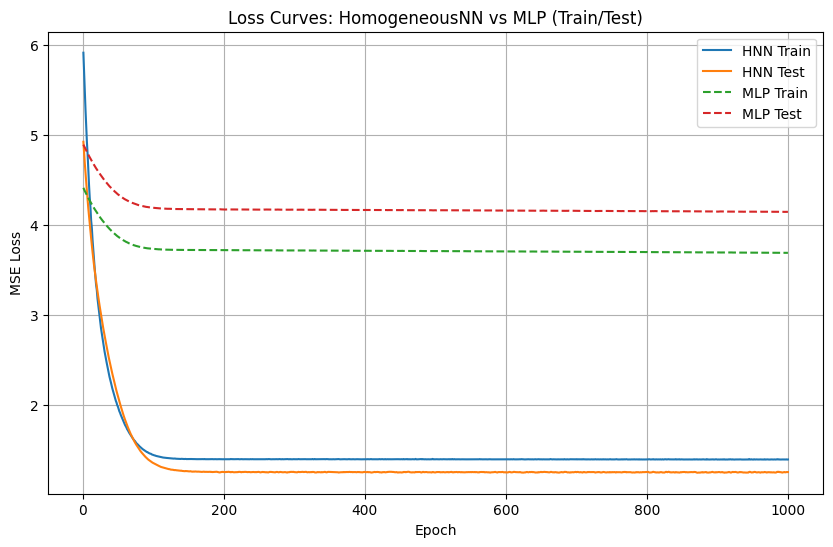

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-4, weight_decay=1e-4)

# --- Training with validation and test evaluations ---
num_epochs = 1000

train_loss_h = []
test_loss_h  = []
train_loss_m = []
test_loss_m  = []

for epoch in range(num_epochs):
    # Training phase
    model_hnn.train()
    model_mlp.train()
    running_h = 0.0
    running_m = 0.0

    for batch_x, batch_y in train_loader:
        # HomogeneousNN
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP
        opt_mlp.zero_grad()
        pred_m = model_mlp(batch_x)
        loss_m = criterion(pred_m, batch_y)
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    # Evaluation phase
    model_hnn.eval()
    model_mlp.eval()
    val_h, val_m = 0.0, 0.0
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            pm = model_mlp(bx)
            test_h += criterion(ph, by).item()
            test_m += criterion(pm, by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()


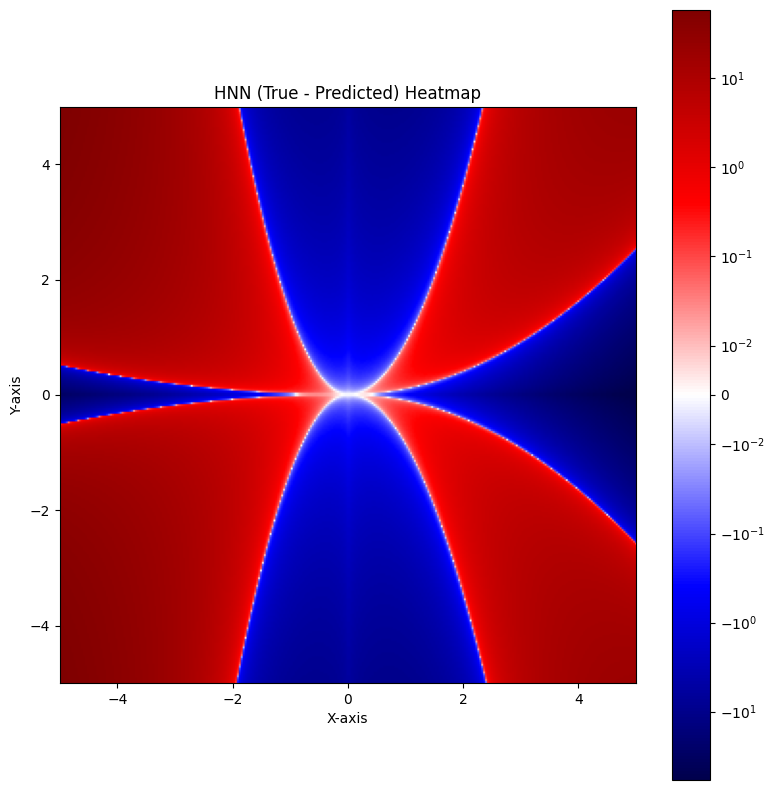

Grid MSE: 1.9117e+02


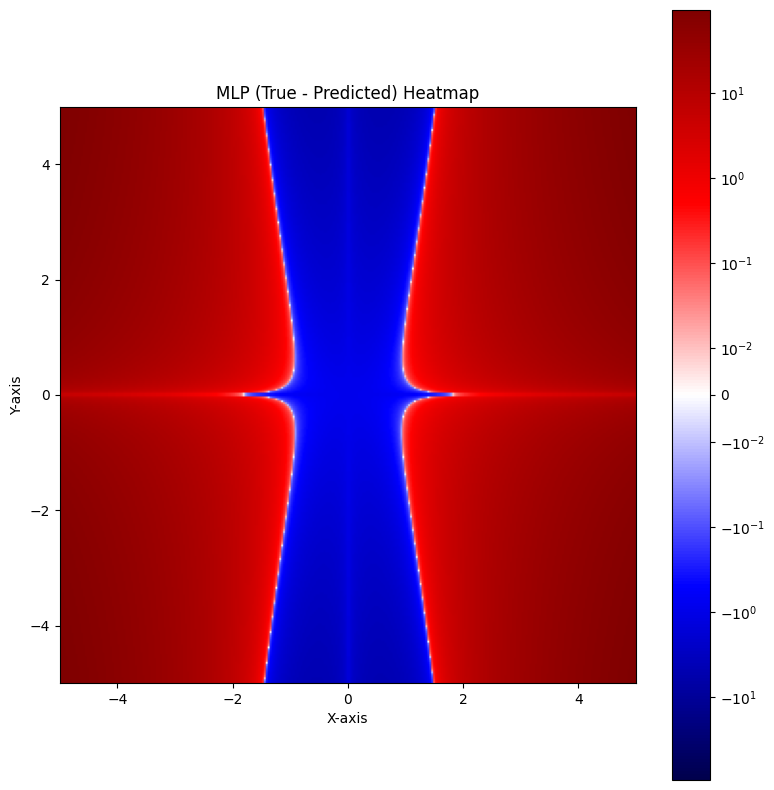

Grid MSE: 8.8648e+02


In [8]:
from plots_utils import plot_model_heatmaps 

bound = 5
plot_model_heatmaps(model_hnn, f_anisotropic, Gd, P, nu, bound)
plot_model_heatmaps(model_mlp, f_anisotropic, Gd, P, nu, bound)

## HNN vs MLP + homogeneity regularization

In [9]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn

# --- Define models ---
hidden_dim = 64
output_dim = 1

# 1) HomogeneousNN (your custom model)
model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

# 2) Standard MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.name = 'MLP'
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim).to(device)

model_hnn.apply(initialize_weights)
model_mlp.apply(initialize_weights)

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Epoch 100 | HNN Train: 1.6010 | Test: 1.5922 || MLP Train: 4.2527 | Test: 4.7213
Epoch 200 | HNN Train: 1.3976 | Test: 1.2600 || MLP Train: 3.9378 | Test: 4.3738
Epoch 300 | HNN Train: 1.3950 | Test: 1.2514 || MLP Train: 3.4317 | Test: 3.7480
Epoch 400 | HNN Train: 1.3939 | Test: 1.2488 || MLP Train: 2.8565 | Test: 3.0881
Epoch 500 | HNN Train: 1.3937 | Test: 1.2479 || MLP Train: 2.4589 | Test: 2.5568
Epoch 600 | HNN Train: 1.3917 | Test: 1.2486 || MLP Train: 2.1948 | Test: 2.2067
Epoch 700 | HNN Train: 1.3907 | Test: 1.2472 || MLP Train: 2.0221 | Test: 1.9743
Epoch 800 | HNN Train: 1.3899 | Test: 1.2487 || MLP Train: 1.9041 | Test: 1.7974
Epoch 900 | HNN Train: 1.3869 | Test: 1.2471 || MLP Train: 1.7640 | Test: 1.6408
Epoch 1000 | HNN Train: 1.3855 | Test: 1.2453 || MLP Train: 1.6705 | Test: 1.5158
Training complete.


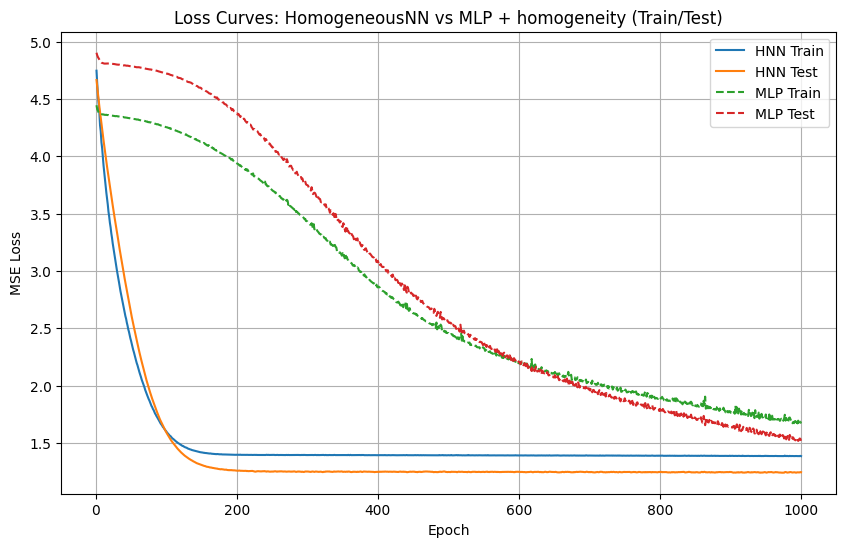

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from hnn_utils import is_diagonalizable, batch_bisection_solve_diag, dilation_batch_diag, compute_alpha_beta

if is_diagonalizable(Gd):
    device = Gd.device
    eigvals, eigvecs = torch.linalg.eig(Gd)
    V = eigvecs.to(device)
    V_inv = torch.linalg.inv(V).to(device)
    lam = eigvals.to(device)

alpha, beta = compute_alpha_beta(Gd, P)


# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-4, weight_decay=1e-4)

# --- Training with validation and test evaluations ---
num_epochs = 1000

train_loss_h = []
test_loss_h  = []
train_loss_m = []
test_loss_m  = []

for epoch in range(num_epochs):
    # Training phase
    model_hnn.train()
    model_mlp.train()
    running_h = 0.0
    running_m = 0.0

    for batch_x, batch_y in train_loader:
        # HomogeneousNN
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP + homogeneity loss constrains
        opt_mlp.zero_grad()
        pred_m = model_mlp(batch_x)
        
        with torch.no_grad():
                S = batch_bisection_solve_diag(lam, V, V_inv, P, batch_x, alpha, beta, tol=1e-4, max_iter=1000)

        x_sphere = dilation_batch_diag(lam, V, V_inv, -S, batch_x)
        scale_up = torch.exp(nu * S).unsqueeze(-1)
        
        mse = criterion(pred_m, batch_y)
        h_constrains = criterion(pred_m, scale_up * model_mlp(x_sphere))
        loss_m = mse + h_constrains
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    # Evaluation phase
    model_hnn.eval()
    model_mlp.eval()
    val_h, val_m = 0.0, 0.0
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            pm = model_mlp(bx)
            test_h += criterion(ph, by).item()
            test_m += criterion(pm, by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP + homogeneity (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()


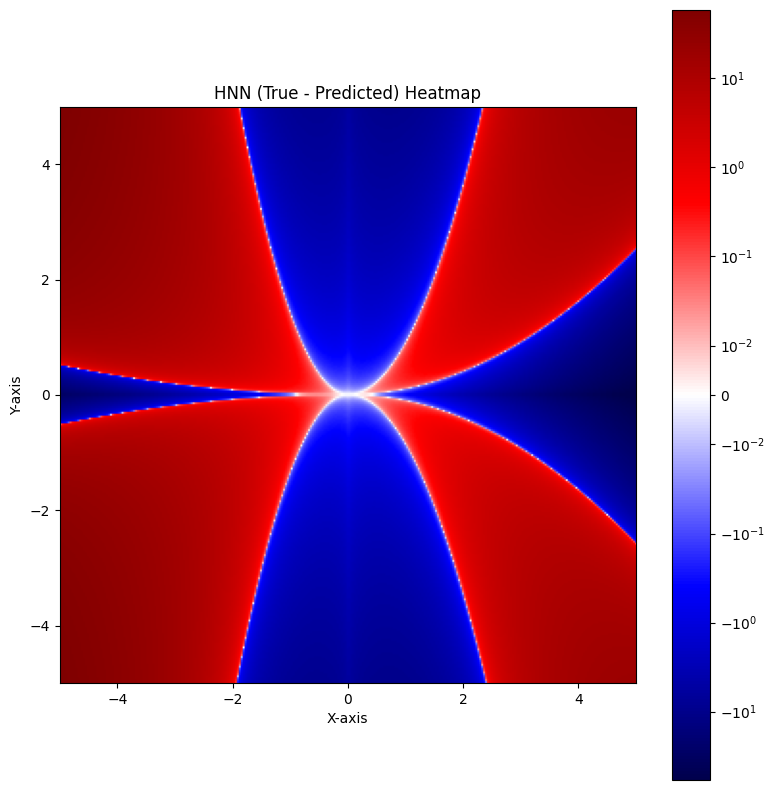

Grid MSE: 1.9038e+02


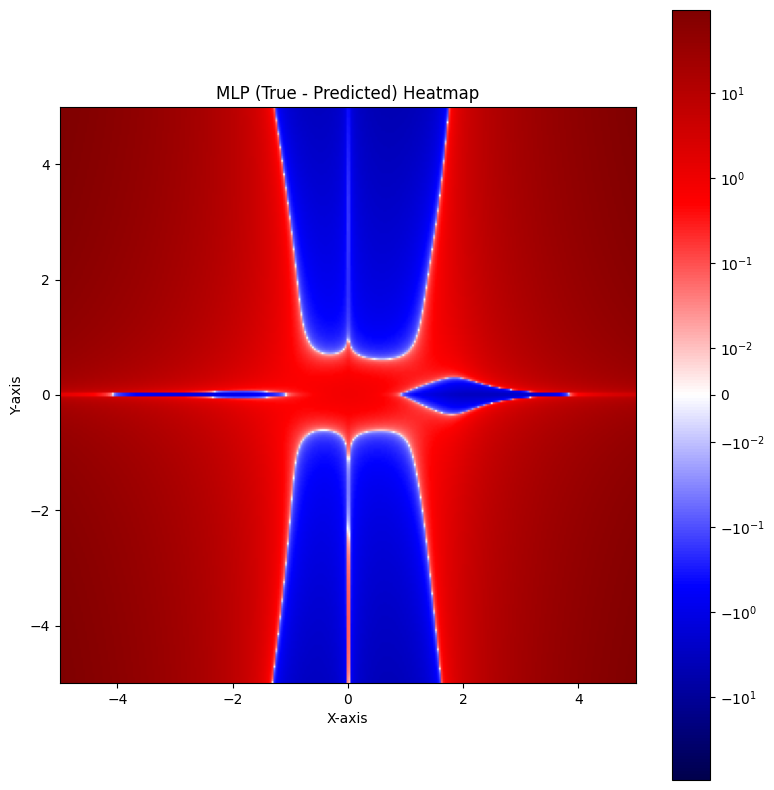

Grid MSE: 7.7446e+02


In [11]:
bound = 5
plot_model_heatmaps(model_hnn, f_anisotropic, Gd, P, nu, bound)
plot_model_heatmaps(model_mlp, f_anisotropic, Gd, P, nu, bound)

# HNN MSE vs HNN Homogeneous weigthed loss

In [18]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn

# --- Define models ---
hidden_dim = 128
output_dim = 1

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

model_hnn_WL = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

model_hnn.apply(initialize_weights)
model_hnn_WL.apply(initialize_weights)

HomogeneousNN(
  (net_on_sphere): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=False)
  )
)

In [19]:
def hnn_loss(pred_y, target_y, S, nu):
    mse = (pred_y - target_y)**2
    weights = torch.exp(-2*nu * S).unsqueeze(-1)
    weighted_mse = weights * mse
    return weighted_mse.mean()

Epoch 100 | HNN (MSE) Train: 1.4420 | Test: 1.3460 || HNN (Weighted) Train: 0.1756 | Test: 0.1777
Epoch 200 | HNN (MSE) Train: 1.3943 | Test: 1.2513 || HNN (Weighted) Train: 0.1754 | Test: 0.1775
Epoch 300 | HNN (MSE) Train: 1.3939 | Test: 1.2522 || HNN (Weighted) Train: 0.1752 | Test: 0.1773
Epoch 400 | HNN (MSE) Train: 1.3934 | Test: 1.2533 || HNN (Weighted) Train: 0.1750 | Test: 0.1770
Epoch 500 | HNN (MSE) Train: 1.3940 | Test: 1.2516 || HNN (Weighted) Train: 0.1747 | Test: 0.1767
Epoch 600 | HNN (MSE) Train: 1.3928 | Test: 1.2519 || HNN (Weighted) Train: 0.1744 | Test: 0.1764
Epoch 700 | HNN (MSE) Train: 1.3943 | Test: 1.2451 || HNN (Weighted) Train: 0.1740 | Test: 0.1760
Epoch 800 | HNN (MSE) Train: 1.3926 | Test: 1.2493 || HNN (Weighted) Train: 0.1736 | Test: 0.1756
Epoch 900 | HNN (MSE) Train: 1.3910 | Test: 1.2448 || HNN (Weighted) Train: 0.1730 | Test: 0.1751
Epoch 1000 | HNN (MSE) Train: 1.3927 | Test: 1.2518 || HNN (Weighted) Train: 0.1724 | Test: 0.1745
Training complete.


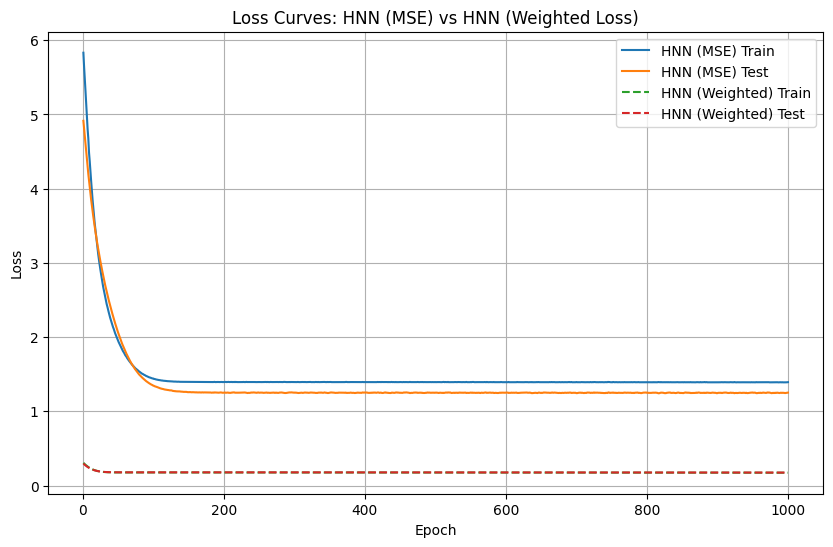

In [20]:
# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn     = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_hnn_WL  = optim.Adam(model_hnn_WL.parameters(), lr=1e-4, weight_decay=1e-4)

# --- Training setup ---
num_epochs = 1000
train_loss_h     = []
test_loss_h      = []
train_loss_hWL   = []
test_loss_hWL    = []

for epoch in range(num_epochs):
    model_hnn.train()
    model_hnn_WL.train()
    running_h = 0.0
    running_hWL = 0.0

    for batch_x, batch_y in train_loader:
        # --- Standard HNN with MSE ---
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # --- HNN with Weighted Loss ---
        opt_hnn_WL.zero_grad()
        pred_hWL = model_hnn_WL(batch_x)

        with torch.no_grad():
            S = batch_bisection_solve_diag(lam, V, V_inv, P, batch_x, alpha, beta, tol=1e-4, max_iter=1000)

        loss_hWL = hnn_loss(pred_hWL, batch_y, S, nu)
        loss_hWL.backward()
        opt_hnn_WL.step()
        running_hWL += loss_hWL.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_hWL.append(running_hWL / len(train_loader))

    # --- Evaluation phase ---
    model_hnn.eval()
    model_hnn_WL.eval()
    test_h, test_hWL = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            phWL = model_hnn_WL(bx)
            S = batch_bisection_solve_diag(lam, V, V_inv, P, bx, alpha, beta, tol=1e-4, max_iter=1000)
            test_h += criterion(ph, by).item()
            test_hWL += hnn_loss(phWL, by, S, nu).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_hWL.append(test_hWL / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN (MSE) Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| HNN (Weighted) Train: {train_loss_hWL[-1]:.4f} | Test: {test_loss_hWL[-1]:.4f}")

print("Training complete.")
# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN (MSE) Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN (MSE) Test')
plt.plot(range(1, num_epochs+1), train_loss_hWL, label='HNN (Weighted) Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_hWL,  label='HNN (Weighted) Test', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves: HNN (MSE) vs HNN (Weighted Loss)')
plt.legend()
plt.grid(True)
plt.show()



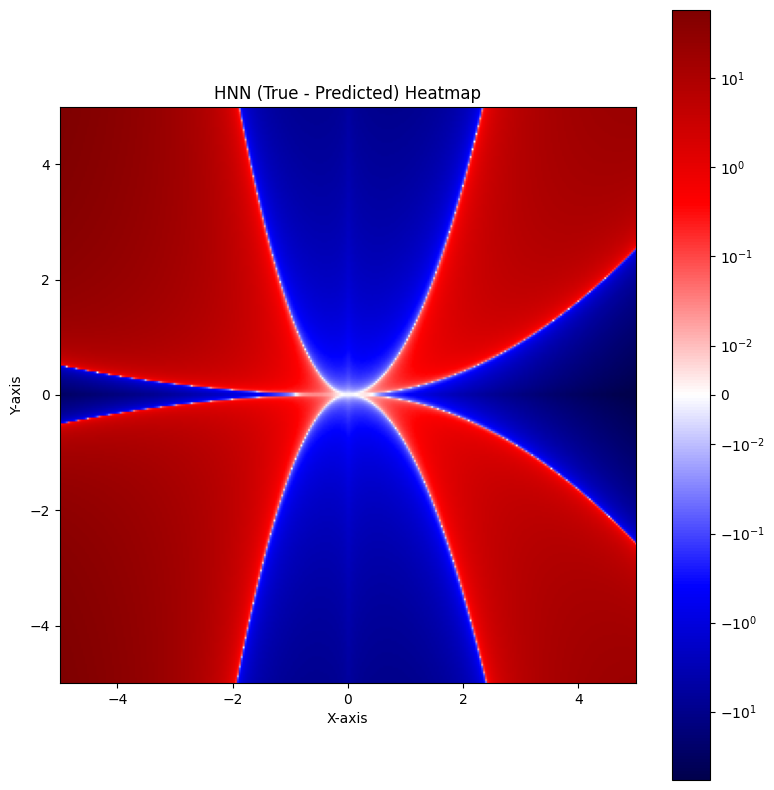

Grid MSE: 1.9146e+02


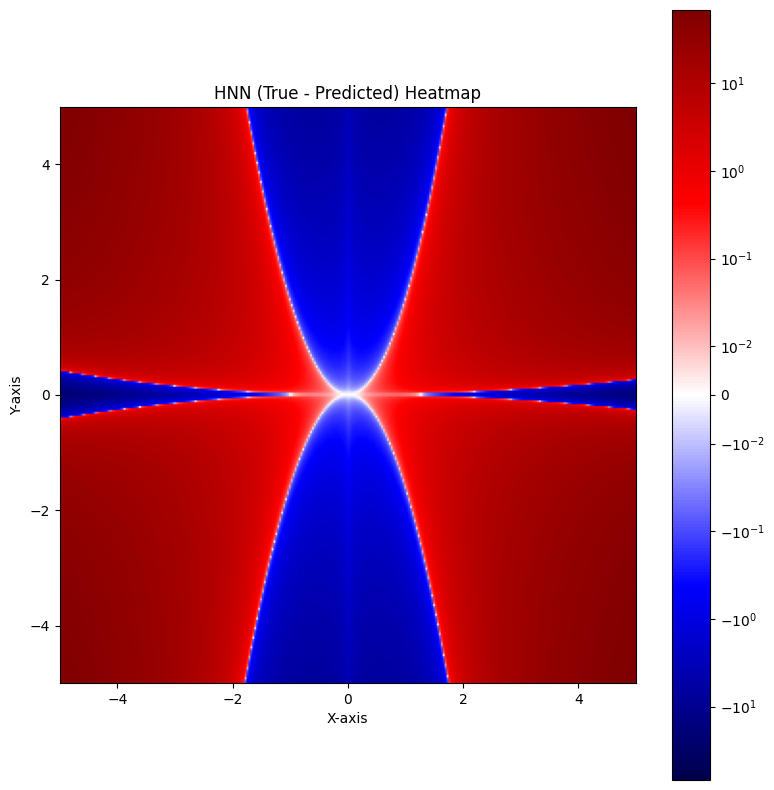

Grid MSE: 3.9278e+02


In [21]:
bound = 5
plot_model_heatmaps(model_hnn, f_anisotropic, Gd, P, nu, bound)
plot_model_heatmaps(model_hnn_WL, f_anisotropic, Gd, P, nu, bound)